In [1]:
# import scvi
from typing import Dict, Iterable, Optional
# import scvi
import numpy as np
import torch
import pandas as pd
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
# from complementary_models import HALOMASKVIR as HALOVI
# from complementary_models import HALOMASKVAE as HALOVAE

import scanpy as sc
import scvi
from matplotlib import pyplot as plt

path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

Global seed set to 0
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
HALOVI.setup_anndata(adata_mvi,time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)     

self.w_a :1
yes there is aligner


In [3]:
model = model.load("model_hair_align_causal01_20", adata_mvi)
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

INFO     File model_hair_align_causal01_20/model.pt already downloaded                       
self.w_a :1
yes there is aligner


In [7]:
with torch.no_grad():
    latent_rna_indep_pred = model.module.decouple_aligner(torch.tensor(latent_atac_indep))
    latent_rna_dep_pred = model.module.couple_aligner(torch.tensor(latent_atac_dep))
adata_mvi.obsm["latent_expr_pred"] = np.concatenate([latent_rna_dep_pred.cpu().numpy(), latent_rna_dep_pred.cpu().numpy()], axis=1)

In [24]:
## plot chromatin potential of each cell
def compute_chrom_potential_eu(decouple_acc,  couple_acc):
    if decouple_acc.shape != couple_acc.shape:
        raise ValueError("Matrices must have the same shape.")
    
    # Compute the difference couple_acc
    diff_matrix = decouple_acc - couple_acc
    
    # Square the differences
    squared_diff_matrix = np.square(diff_matrix)
    
    # Sum the squares column-wise
    sum_squared_diff = np.sum(squared_diff_matrix, axis=1)
    
    # Square root of the sum gives the Euclidean distance
    distances = np.sqrt(sum_squared_diff)


    min_distance = np.min(distances)
    max_distance = np.max(distances)
    normalized_distances = (distances - min_distance) / (max_distance - min_distance)
    
    
    return normalized_distances


def compute_chrom_potential_cos(matrix1, matrix2):
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape.")
    
    dot_product = np.sum(matrix1 * matrix2, axis=1)
    magnitude1 = np.sqrt(np.sum(matrix1**2, axis=1))
    magnitude2 = np.sqrt(np.sum(matrix2**2, axis=1))
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    cosine_distance = 1 - cosine_similarity
    
    # Normalize the distances
    # min_distance = np.min(cosine_distance)
    # max_distance = np.max(cosine_distance)
    # normalized_distances = (cosine_distance - min_distance) / (max_distance - min_distance)
    
    return cosine_distance
from numpy.linalg import inv 

def residue_potential(matrix1, matrix2, time):
    X = matrix1
    Y = matrix2

    b = inv(X.T.dot(X)).dot(X.T).dot(Y)

    Yhat = X.dot(b)
    Y_Residual = Yhat - Y
    Y_Residual_3 = np.mean(np.abs(Y_Residual),axis=1)

    z = np.polyfit(time, Y_Residual_3, 3)
    p = np.poly1d(z)

    Y_Residual_smooth = p(time)

    return Y_Residual_smooth


def rbf_kernel(x, y, gamma=0.5):
    return np.exp(-gamma * np.linalg.norm(x-y)**2)

def rbf_kernel_inv(x, y, gamma=0.5):
    return np.exp(gamma * np.linalg.norm(x-y)**2)

# Polynomial Kernel Function
def polynomial_kernel(x, y, degree=3, r=1, gamma=1):
    return (gamma * np.dot(x, y) + r) ** degree

# Linear Kernel Function
def linear_kernel(x, y, gamma=1):
    return np.dot(x, y)




def compute_chrom_potential(X, Y, kernel_function=rbf_kernel, gamma=5):
    """
    Compute the kernel similarities between each row of matrix X and each row of matrix Y.
    
    Parameters:
    - X: numpy array of shape (n_samples_X, n_features)
    - Y: numpy array of shape (n_samples_Y, n_features)
    - kernel_function: function to compute the kernel. Default is RBF kernel.
    - gamma: Parameter for the RBF kernel.
    
    Returns:
    - similarities: numpy array of shape (n_samples_X, n_samples_Y) containing the kernel similarities.
    """
    n_samples_X, n_features_X = X.shape
    n_samples_Y, n_features_Y = Y.shape
    assert n_features_X == n_features_Y, "The number of features in X and Y must be the same."
    
    similarities = np.zeros((n_samples_X))
    for i in range(n_samples_X):
            similarities[i] = kernel_function(X[i, :], Y[i, :], gamma=gamma)
    return np.array(similarities)

def smooth_potential_knn(similarity, adata, n=50):
    ncell = adata.shape[0]
    smooth_sim = []
    for i in range(ncell):
        knn_cells = adata_mvi.obsp["connectivities"][i, :].toarray()[0]
        knn_cells = np.argsort(knn_cells)[-n:]
        if n!=1:
            knn_cells = np.append(knn_cells, i)
        else:
            knn_cells= [i]    
        smooth_sim.append(np.mean(similarity[knn_cells]))
    return np.array(smooth_sim)



In [130]:
adata_mvi.obsm["latent"] = np.concatenate([latent_expr, latent_acc], axis=1)
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=50, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1, spread=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


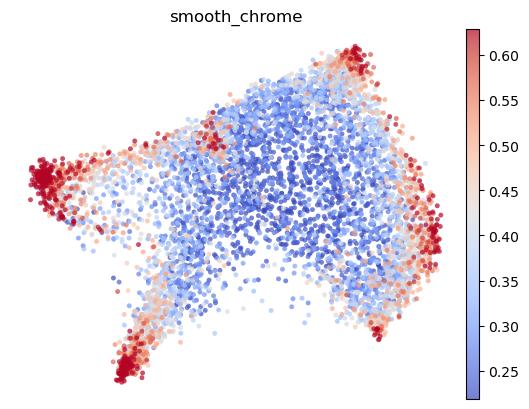

In [131]:
potential = compute_chrom_potential(latent_acc, latent_expr, kernel_function=linear_kernel, gamma=0.1)
adata_mvi.obs["chromepot"] = potential
smoothed =  smooth_potential_knn(potential, adata_mvi, n=20)
min_val = np.min(smoothed)
max_val = np.max(smoothed)
smoothed = (smoothed - min_val) / (max_val - min_val)
adata_mvi.obs["smooth_chrome"] = smoothed
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.7, add_outline=False,
        outline_width=(0.1,0), color=["smooth_chrome"],  color_map = 'coolwarm', vmax="p95", vmin="p15", save="chrom_potential.pdf") 

In [136]:
adata_mvi.obsm["latent_atac"] = latent_acc
adata_mvi.obsm["latent_expr"] = latent_expr

In [158]:
sc.pp.neighbors(adata_mvi, use_rep = 'atac_indep',n_neighbors=30, metric = 'manhattan')
sc.tl.leiden(adata_mvi)
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1, spread=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


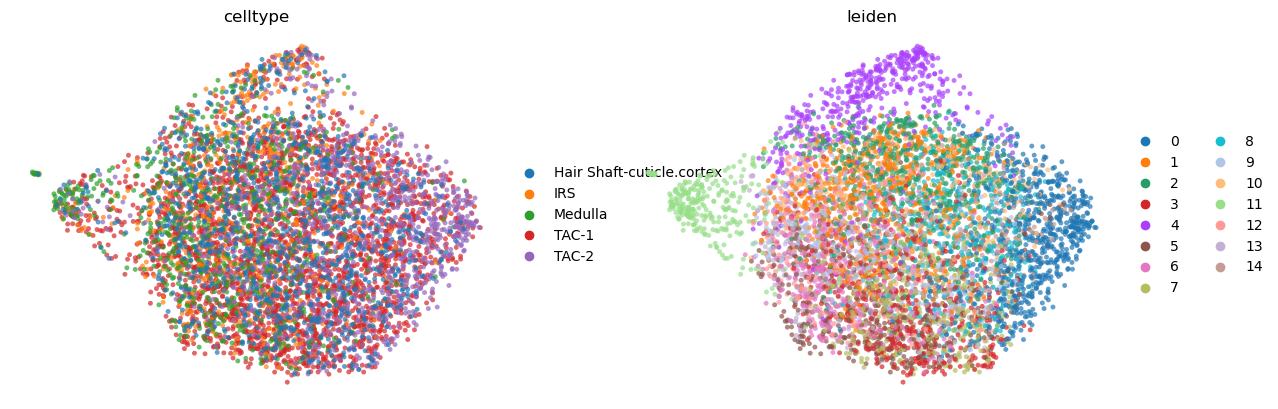

In [159]:
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.7, add_outline=False,
        outline_width=(0.1,0), color=["celltype", "leiden"], color_map = 'coolwarm', vmin="p05", vmax="p95", use_raw=False)         

In [160]:
adata_mvi

AnnData object with n_obs × n_vars = 6436 × 113615
    obs: 'index', 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'chromepot', 'smooth_chrome', 'leiden'
    var: 'feature_types', 'modality', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'celltype_colors', 'leiden', 'leiden_colors'
    obsm: 'latent', 'X_umap', 'atac_indep'
    obsp: 'distances', 'connectivities'

In [9]:
chrom_potent_scarlink = pd.read_csv("data/mouse_skin_chromatin_potential.csv", sep='\t')
chrom_potent_scarlink

,x_0,x_1,v_0,v_1,umap_0,umap_1,barcode_rna
0,1.760810,-8.762940,0.609198,-0.195670,1.760810,-8.762940,R1.01.R2.02.R3.21.P1.56
1,8.376727,-13.873216,0.001028,-0.014592,8.376727,-13.873216,R1.01.R2.03.R3.61.P1.54
2,3.499622,-8.509009,-0.149176,0.179542,3.499622,-8.509009,R1.01.R2.06.R3.64.P1.56
3,1.287024,-9.679595,0.217202,0.223756,1.287024,-9.679595,R1.01.R2.06.R3.83.P1.55
4,1.679156,-8.890386,0.653522,-0.123084,1.679156,-8.890386,R1.01.R2.11.R3.86.P1.56
...,...,...,...,...,...,...,...
6426,7.729002,-12.868301,0.012411,-0.091254,7.729002,-12.868301,R1.96.R2.87.R3.63.P1.55
6427,7.876560,-12.856358,0.154876,-0.138329,7.876560,-12.856358,R1.96.R2.88.R3.36.P1.53
6428,0.979684,-10.590413,-0.431927,-0.113401,0.979684,-10.590413,R1.96.R2.92.R3.27.P1.54
6429,2.510538,-11.530611,-0.581862,0.665614,2.510538,-11.530611,R1.96.R2.92.R3.28.P1.56


In [10]:
barcodes = pd.read_csv("data/GSM4156597_skin_celltype.txt", sep="\t")
barcodes

,atac.bc,rna.bc,celltype
0,R1.01.R2.01.R3.06.P1.07,R1.01.R2.01.R3.06.P1.55,Dermal Fibroblast
1,R1.01.R2.03.R3.68.P1.07,R1.01.R2.03.R3.68.P1.55,Dermal Fibroblast
2,R1.01.R2.05.R3.15.P1.05,R1.01.R2.05.R3.15.P1.53,Dermal Fibroblast
3,R1.01.R2.05.R3.40.P1.07,R1.01.R2.05.R3.40.P1.55,Dermal Fibroblast
4,R1.01.R2.05.R3.49.P1.07,R1.01.R2.05.R3.49.P1.55,Dermal Fibroblast
...,...,...,...
34769,R1.92.R2.79.R3.05.P1.08,R1.92.R2.79.R3.05.P1.56,Melanocyte
34770,R1.93.R2.20.R3.18.P1.05,R1.93.R2.20.R3.18.P1.53,Melanocyte
34771,R1.93.R2.80.R3.62.P1.07,R1.93.R2.80.R3.62.P1.55,Melanocyte
34772,R1.93.R2.91.R3.82.P1.08,R1.93.R2.91.R3.82.P1.56,Melanocyte


In [11]:
barcodes.columns

Index(['atac.bc', 'rna.bc', 'celltype'], dtype='object')

In [12]:
barcodes = barcodes.rename(columns={'rna.bc': "barcode_rna"})
barcodes

,atac.bc,barcode_rna,celltype
0,R1.01.R2.01.R3.06.P1.07,R1.01.R2.01.R3.06.P1.55,Dermal Fibroblast
1,R1.01.R2.03.R3.68.P1.07,R1.01.R2.03.R3.68.P1.55,Dermal Fibroblast
2,R1.01.R2.05.R3.15.P1.05,R1.01.R2.05.R3.15.P1.53,Dermal Fibroblast
3,R1.01.R2.05.R3.40.P1.07,R1.01.R2.05.R3.40.P1.55,Dermal Fibroblast
4,R1.01.R2.05.R3.49.P1.07,R1.01.R2.05.R3.49.P1.55,Dermal Fibroblast
...,...,...,...
34769,R1.92.R2.79.R3.05.P1.08,R1.92.R2.79.R3.05.P1.56,Melanocyte
34770,R1.93.R2.20.R3.18.P1.05,R1.93.R2.20.R3.18.P1.53,Melanocyte
34771,R1.93.R2.80.R3.62.P1.07,R1.93.R2.80.R3.62.P1.55,Melanocyte
34772,R1.93.R2.91.R3.82.P1.08,R1.93.R2.91.R3.82.P1.56,Melanocyte


In [105]:
chrom_potent_scarlink['sclink'] = (chrom_potent_scarlink['v_0']**2 + chrom_potent_scarlink['v_1']**2)**0.5
chrom_potent_scarlink

,x_0,x_1,v_0,v_1,umap_0,umap_1,barcode_rna,sclink,celltype
atac.bc,,,,,,,,,
R1.01.R2.02.R3.21.P1.08,1.760810,-8.762940,0.609198,-0.195670,1.760810,-8.762940,R1.01.R2.02.R3.21.P1.56,0.639850,IRS
R1.01.R2.03.R3.61.P1.06,8.376727,-13.873216,0.001028,-0.014592,8.376727,-13.873216,R1.01.R2.03.R3.61.P1.54,0.014628,Medulla
R1.01.R2.06.R3.64.P1.08,3.499622,-8.509009,-0.149176,0.179542,3.499622,-8.509009,R1.01.R2.06.R3.64.P1.56,0.233429,TAC-2
R1.01.R2.06.R3.83.P1.07,1.287024,-9.679595,0.217202,0.223756,1.287024,-9.679595,R1.01.R2.06.R3.83.P1.55,0.311839,TAC-1
R1.01.R2.11.R3.86.P1.08,1.679156,-8.890386,0.653522,-0.123084,1.679156,-8.890386,R1.01.R2.11.R3.86.P1.56,0.665012,TAC-1
...,...,...,...,...,...,...,...,...,...
R1.96.R2.87.R3.63.P1.07,7.729002,-12.868301,0.012411,-0.091254,7.729002,-12.868301,R1.96.R2.87.R3.63.P1.55,0.092094,Hair Shaft-cuticle.cortex
R1.96.R2.88.R3.36.P1.05,7.876560,-12.856358,0.154876,-0.138329,7.876560,-12.856358,R1.96.R2.88.R3.36.P1.53,0.207657,Hair Shaft-cuticle.cortex
R1.96.R2.92.R3.27.P1.06,0.979684,-10.590413,-0.431927,-0.113401,0.979684,-10.590413,R1.96.R2.92.R3.27.P1.54,0.446565,TAC-1


In [13]:
chrom_potent_scarlink = pd.merge(chrom_potent_scarlink, barcodes, on="barcode_rna", how="inner")
chrom_potent_scarlink

,x_0,x_1,v_0,v_1,umap_0,umap_1,barcode_rna,atac.bc,celltype
0,1.760810,-8.762940,0.609198,-0.195670,1.760810,-8.762940,R1.01.R2.02.R3.21.P1.56,R1.01.R2.02.R3.21.P1.08,IRS
1,8.376727,-13.873216,0.001028,-0.014592,8.376727,-13.873216,R1.01.R2.03.R3.61.P1.54,R1.01.R2.03.R3.61.P1.06,Medulla
2,3.499622,-8.509009,-0.149176,0.179542,3.499622,-8.509009,R1.01.R2.06.R3.64.P1.56,R1.01.R2.06.R3.64.P1.08,TAC-2
3,1.287024,-9.679595,0.217202,0.223756,1.287024,-9.679595,R1.01.R2.06.R3.83.P1.55,R1.01.R2.06.R3.83.P1.07,TAC-1
4,1.679156,-8.890386,0.653522,-0.123084,1.679156,-8.890386,R1.01.R2.11.R3.86.P1.56,R1.01.R2.11.R3.86.P1.08,TAC-1
...,...,...,...,...,...,...,...,...,...
6426,7.729002,-12.868301,0.012411,-0.091254,7.729002,-12.868301,R1.96.R2.87.R3.63.P1.55,R1.96.R2.87.R3.63.P1.07,Hair Shaft-cuticle.cortex
6427,7.876560,-12.856358,0.154876,-0.138329,7.876560,-12.856358,R1.96.R2.88.R3.36.P1.53,R1.96.R2.88.R3.36.P1.05,Hair Shaft-cuticle.cortex
6428,0.979684,-10.590413,-0.431927,-0.113401,0.979684,-10.590413,R1.96.R2.92.R3.27.P1.54,R1.96.R2.92.R3.27.P1.06,TAC-1
6429,2.510538,-11.530611,-0.581862,0.665614,2.510538,-11.530611,R1.96.R2.92.R3.28.P1.56,R1.96.R2.92.R3.28.P1.08,TAC-2


In [45]:
chrom_potent_scarlink = chrom_potent_scarlink.set_index("atac.bc")
chrom_potent_scarlink

,x_0,x_1,v_0,v_1,umap_0,umap_1,barcode_rna,sclink,celltype
atac.bc,,,,,,,,,
R1.01.R2.02.R3.21.P1.08,1.760810,-8.762940,0.609198,-0.195670,1.760810,-8.762940,R1.01.R2.02.R3.21.P1.56,0.639850,IRS
R1.01.R2.03.R3.61.P1.06,8.376727,-13.873216,0.001028,-0.014592,8.376727,-13.873216,R1.01.R2.03.R3.61.P1.54,0.014628,Medulla
R1.01.R2.06.R3.64.P1.08,3.499622,-8.509009,-0.149176,0.179542,3.499622,-8.509009,R1.01.R2.06.R3.64.P1.56,0.233429,TAC-2
R1.01.R2.06.R3.83.P1.07,1.287024,-9.679595,0.217202,0.223756,1.287024,-9.679595,R1.01.R2.06.R3.83.P1.55,0.311839,TAC-1
R1.01.R2.11.R3.86.P1.08,1.679156,-8.890386,0.653522,-0.123084,1.679156,-8.890386,R1.01.R2.11.R3.86.P1.56,0.665012,TAC-1
...,...,...,...,...,...,...,...,...,...
R1.96.R2.87.R3.63.P1.07,7.729002,-12.868301,0.012411,-0.091254,7.729002,-12.868301,R1.96.R2.87.R3.63.P1.55,0.092094,Hair Shaft-cuticle.cortex
R1.96.R2.88.R3.36.P1.05,7.876560,-12.856358,0.154876,-0.138329,7.876560,-12.856358,R1.96.R2.88.R3.36.P1.53,0.207657,Hair Shaft-cuticle.cortex
R1.96.R2.92.R3.27.P1.06,0.979684,-10.590413,-0.431927,-0.113401,0.979684,-10.590413,R1.96.R2.92.R3.27.P1.54,0.446565,TAC-1


In [15]:
adata_mvi.obs["atac.bc2"] = adata_mvi.obs.apply(lambda row: row["atac.bc"].replace(",", "."), axis=1)
adata_mvi.obs = adata_mvi.obs.set_index("atac.bc2")
adata_mvi.obs

,atac.bc,celltype,latent_time,batch_id,modality,_scvi_batch,_scvi_labels
atac.bc2,,,,,,,
R1.01.R2.06.R3.83.P1.07,"R1.01,R2.06,R3.83,P1.07",TAC-1,0.36658628831505347,1,paired,0,0
R1.01.R2.11.R3.86.P1.08,"R1.01,R2.11,R3.86,P1.08",TAC-1,0.3877175639945546,1,paired,0,0
R1.01.R2.15.R3.09.P1.07,"R1.01,R2.15,R3.09,P1.07",TAC-1,0.14763327208167026,1,paired,0,0
R1.01.R2.17.R3.81.P1.05,"R1.01,R2.17,R3.81,P1.05",TAC-1,0.3565765077510133,1,paired,0,0
R1.01.R2.18.R3.95.P1.06,"R1.01,R2.18,R3.95,P1.06",TAC-1,0.1317079959728127,1,paired,0,0
...,...,...,...,...,...,...,...
R1.96.R2.73.R3.72.P1.08,"R1.96,R2.73,R3.72,P1.08",Hair Shaft-cuticle.cortex,0.34522547501616424,1,paired,0,0
R1.96.R2.82.R3.52.P1.07,"R1.96,R2.82,R3.52,P1.07",Hair Shaft-cuticle.cortex,0.3132587586109149,1,paired,0,0
R1.96.R2.83.R3.68.P1.06,"R1.96,R2.83,R3.68,P1.06",Hair Shaft-cuticle.cortex,0.34390561478075676,1,paired,0,0


In [16]:
chrom_potent_scarlink = chrom_potent_scarlink.set_index("atac.bc")
chrom_potent_scarlink

,x_0,x_1,v_0,v_1,umap_0,umap_1,barcode_rna,celltype
atac.bc,,,,,,,,
R1.01.R2.02.R3.21.P1.08,1.760810,-8.762940,0.609198,-0.195670,1.760810,-8.762940,R1.01.R2.02.R3.21.P1.56,IRS
R1.01.R2.03.R3.61.P1.06,8.376727,-13.873216,0.001028,-0.014592,8.376727,-13.873216,R1.01.R2.03.R3.61.P1.54,Medulla
R1.01.R2.06.R3.64.P1.08,3.499622,-8.509009,-0.149176,0.179542,3.499622,-8.509009,R1.01.R2.06.R3.64.P1.56,TAC-2
R1.01.R2.06.R3.83.P1.07,1.287024,-9.679595,0.217202,0.223756,1.287024,-9.679595,R1.01.R2.06.R3.83.P1.55,TAC-1
R1.01.R2.11.R3.86.P1.08,1.679156,-8.890386,0.653522,-0.123084,1.679156,-8.890386,R1.01.R2.11.R3.86.P1.56,TAC-1
...,...,...,...,...,...,...,...,...
R1.96.R2.87.R3.63.P1.07,7.729002,-12.868301,0.012411,-0.091254,7.729002,-12.868301,R1.96.R2.87.R3.63.P1.55,Hair Shaft-cuticle.cortex
R1.96.R2.88.R3.36.P1.05,7.876560,-12.856358,0.154876,-0.138329,7.876560,-12.856358,R1.96.R2.88.R3.36.P1.53,Hair Shaft-cuticle.cortex
R1.96.R2.92.R3.27.P1.06,0.979684,-10.590413,-0.431927,-0.113401,0.979684,-10.590413,R1.96.R2.92.R3.27.P1.54,TAC-1


In [17]:
result = pd.merge(adata_mvi.obs, chrom_potent_scarlink, how='inner', left_index=True, right_index=True)
result


,atac.bc,celltype_x,latent_time,batch_id,modality,_scvi_batch,_scvi_labels,x_0,x_1,v_0,v_1,umap_0,umap_1,barcode_rna,celltype_y
R1.01.R2.06.R3.83.P1.07,"R1.01,R2.06,R3.83,P1.07",TAC-1,0.36658628831505347,1,paired,0,0,1.287024,-9.679595,0.217202,0.223756,1.287024,-9.679595,R1.01.R2.06.R3.83.P1.55,TAC-1
R1.01.R2.11.R3.86.P1.08,"R1.01,R2.11,R3.86,P1.08",TAC-1,0.3877175639945546,1,paired,0,0,1.679156,-8.890386,0.653522,-0.123084,1.679156,-8.890386,R1.01.R2.11.R3.86.P1.56,TAC-1
R1.01.R2.15.R3.09.P1.07,"R1.01,R2.15,R3.09,P1.07",TAC-1,0.14763327208167026,1,paired,0,0,3.105708,-11.200886,-0.251110,0.441977,3.105708,-11.200886,R1.01.R2.15.R3.09.P1.55,TAC-1
R1.01.R2.17.R3.81.P1.05,"R1.01,R2.17,R3.81,P1.05",TAC-1,0.3565765077510133,1,paired,0,0,1.942233,-9.400400,-0.092633,0.308989,1.942233,-9.400400,R1.01.R2.17.R3.81.P1.53,TAC-1
R1.01.R2.18.R3.95.P1.06,"R1.01,R2.18,R3.95,P1.06",TAC-1,0.1317079959728127,1,paired,0,0,0.205076,-10.888144,0.406928,0.004971,0.205076,-10.888144,R1.01.R2.18.R3.95.P1.54,TAC-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R1.96.R2.73.R3.72.P1.08,"R1.96,R2.73,R3.72,P1.08",Hair Shaft-cuticle.cortex,0.34522547501616424,1,paired,0,0,3.055355,-9.896197,0.576253,-0.328368,3.055355,-9.896197,R1.96.R2.73.R3.72.P1.56,Hair Shaft-cuticle.cortex
R1.96.R2.82.R3.52.P1.07,"R1.96,R2.82,R3.52,P1.07",Hair Shaft-cuticle.cortex,0.3132587586109149,1,paired,0,0,6.997319,-12.901021,0.640521,0.026185,6.997319,-12.901021,R1.96.R2.82.R3.52.P1.55,Hair Shaft-cuticle.cortex
R1.96.R2.83.R3.68.P1.06,"R1.96,R2.83,R3.68,P1.06",Hair Shaft-cuticle.cortex,0.34390561478075676,1,paired,0,0,5.877316,-13.320601,0.641080,0.065640,5.877316,-13.320601,R1.96.R2.83.R3.68.P1.54,Hair Shaft-cuticle.cortex
R1.96.R2.87.R3.63.P1.07,"R1.96,R2.87,R3.63,P1.07",Hair Shaft-cuticle.cortex,0.47559526321666107,1,paired,0,0,7.729002,-12.868301,0.012411,-0.091254,7.729002,-12.868301,R1.96.R2.87.R3.63.P1.55,Hair Shaft-cuticle.cortex


In [132]:
adata_mvi2 = adata_mvi[result.index]

In [28]:
adata_mvi2

View of AnnData object with n_obs × n_vars = 6431 × 113615
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'chromepot', 'smooth_chrome'
    var: 'feature_types', 'modality', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap'
    obsm: 'latent_expr_pred', 'latent_atac', 'latent_expr', 'latent', 'X_umap'
    obsp: 'distances', 'connectivities'

In [133]:
adata_mvi2.obsm["X_umap2"] = result[["umap_0", "umap_1"]].to_numpy()

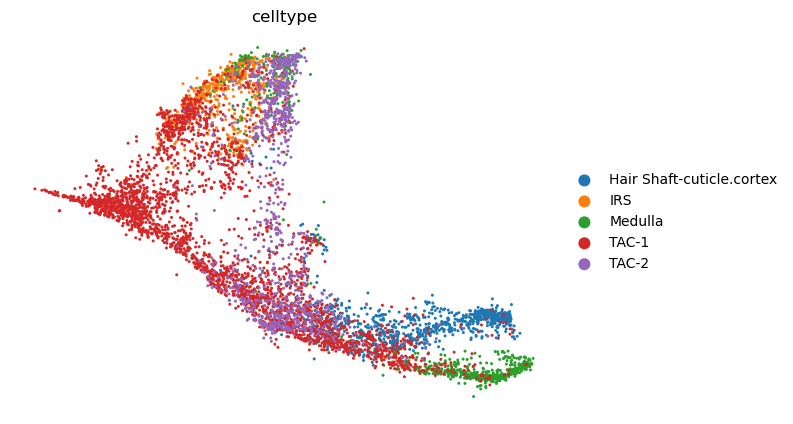

In [30]:
sc.pl.scatter(adata_mvi2,color="celltype",basis="umap2",frameon=False)


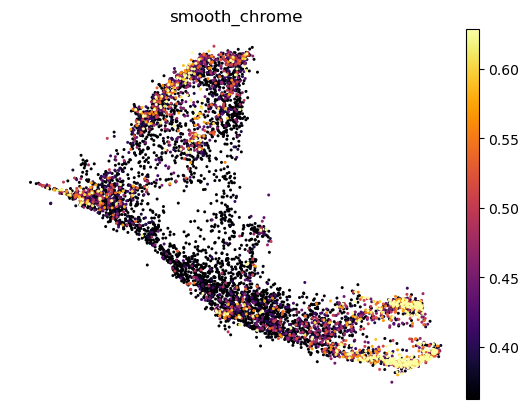

In [141]:
adata_mvi2.obsm['X_umap'] = adata_mvi2.obsm['X_umap2']
sc.pl.umap(adata_mvi2,color="smooth_chrome",frameon=False,color_map="inferno", vmax="p95", vmin="p55")


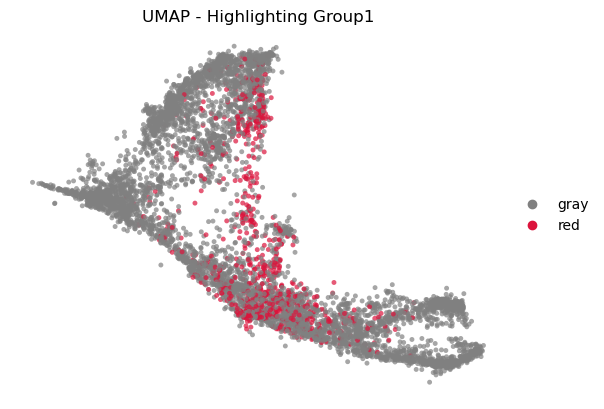

In [174]:
custom_palette = {
    'red': 'crimson',  # Color for the group of interest
    'gray': 'gray'   # Default color for all other groups
}
adata_mvi2.obs['color_group'] = 'gray'

# Now, for cells belonging to the group of interest, set a different color
# For example, setting 'Group1' to be colored 'red'
adata_mvi2.obs.loc[adata_mvi2.obs['leiden'] == '0', 'color_group'] = 'red'

# Plot UMAP with cells colored based on 'color_group'
# # Cells not in 'Group1' will be gray, and 'Group1' cells will be red
# sc.pl.umap(atac_data, color='color_group', title='UMAP - Highlighting Group1', palette=custom_palette, size = 50, alpha = 0.7, add_outline=False, frameon=False,
#         outline_width=(0.1,0),save="hightlight-decouple.pdf")
 


In [35]:
def smooth_arrows(x, y, u, v, smooth_w=50, min_count=5, take_top=0):
    """Smooth arrows in each window.
    
    Parameters
    ----------
    x : [float]
        Starting x-coordinates for the arrows.
    y : [float]
        Starting y-coordinates for the arrows.
    u : [float]
        Length of arrows in x-axis.
    v : [float]
        Length of arrows in y-axis.
    smooth_w : int
        Create smooth_w X smooth_w windows to smooth arrows over.
    min_count : int
        Minimum number of arrows in a window required to smooth.
    take_top : int
        Number of top arrows to select per window.
    
    Returns
    -------
    x_ms, y_ms, Ex_ms, Ey_ms
        Smoothed arrow coordinates and arrow sizes.
    """

    x_ms = []
    y_ms = []
    Ex_ms = []
    Ey_ms = []

    x_window = (np.max(x) - np.min(x)) / smooth_w
    y_window = (np.max(y) - np.min(y)) / smooth_w

    for i in np.arange(np.min(x), np.max(x), x_window):
        for j in np.arange(np.min(y), np.max(y), y_window):
            idx = (x > i) & (x < (i + x_window)) & (y > j) & (y < (j + y_window))
            if np.sum(idx) < min_count:
                continue
            if take_top == 0:
                x_m = np.mean(x[idx])
                y_m = np.mean(y[idx])
                Ex_m = np.mean(u[idx])
                Ey_m = np.mean(v[idx])

            else:
                top_idx = np.argsort(w[idx])[-take_top:]
                x_m = np.mean(x[idx][top_idx])
                y_m = np.mean(y[idx][top_idx])
                Ex_m = np.mean(u[idx][top_idx])
                Ey_m = np.mean(v[idx][top_idx])
            x_ms.append(x_m)
            y_ms.append(y_m)
            Ex_ms.append(Ex_m)
            Ey_ms.append(Ey_m)

    x_ms = np.array(x_ms)
    y_ms = np.array(y_ms)
    Ex_ms = np.array(Ex_ms)
    Ey_ms = np.array(Ey_ms)
    return x_ms, y_ms, Ex_ms, Ey_ms

<Figure size 500x500 with 0 Axes>

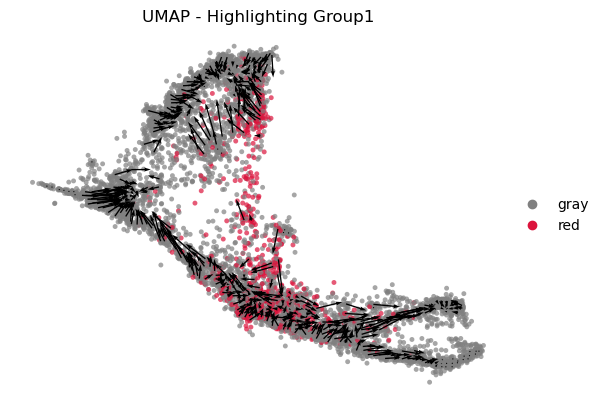

In [200]:
fig = plt.figure(figsize=[5,5])
x_smooth, y_smooth, u_smooth, v_smooth = smooth_arrows(adata_mvi2.obs["x_0"], adata_mvi2.obs["x_1"],adata_mvi2.obs["v_0"], adata_mvi2.obs["v_1"],
                                                           smooth_w=80, min_count=5)
E_norm_smooth = np.sqrt(u_smooth**2 + v_smooth**2)


ax = sc.pl.umap(adata_mvi2, color='color_group', title='UMAP - Highlighting Group1', palette=custom_palette, size = 50, alpha = 0.7, add_outline=False, frameon=False,
        outline_width=(0.1,0),show=False)
ax.quiver(x_smooth, y_smooth,
              u_smooth , v_smooth ,
               angles='xy', scale_units='xy')          

In [178]:
adata_mvi2.obs

,index,atac.bc,celltype_x,latent_time,batch_id,modality,_scvi_batch,_scvi_labels,chromepot,smooth_chrome,...,x_0,x_1,v_0,v_1,umap_0,umap_1,barcode_rna,sclink,celltype_y,color_group
R1.01.R2.06.R3.83.P1.07,0,"R1.01,R2.06,R3.83,P1.07",TAC-1,0.36658628831505347,1,paired,0,0,9.294550,0.648221,...,1.287024,-9.679595,0.217202,0.223756,1.287024,-9.679595,R1.01.R2.06.R3.83.P1.55,0.311839,TAC-1,gray
R1.01.R2.11.R3.86.P1.08,1,"R1.01,R2.11,R3.86,P1.08",TAC-1,0.3877175639945546,1,paired,0,0,4.313615,0.652764,...,1.679156,-8.890386,0.653522,-0.123084,1.679156,-8.890386,R1.01.R2.11.R3.86.P1.56,0.665012,TAC-1,red
R1.01.R2.15.R3.09.P1.07,2,"R1.01,R2.15,R3.09,P1.07",TAC-1,0.14763327208167026,1,paired,0,0,-0.251372,0.778293,...,3.105708,-11.200886,-0.251110,0.441977,3.105708,-11.200886,R1.01.R2.15.R3.09.P1.55,0.508331,TAC-1,red
R1.01.R2.17.R3.81.P1.05,3,"R1.01,R2.17,R3.81,P1.05",TAC-1,0.3565765077510133,1,paired,0,0,10.798588,0.698183,...,1.942233,-9.400400,-0.092633,0.308989,1.942233,-9.400400,R1.01.R2.17.R3.81.P1.53,0.322575,TAC-1,gray
R1.01.R2.18.R3.95.P1.06,4,"R1.01,R2.18,R3.95,P1.06",TAC-1,0.1317079959728127,1,paired,0,0,5.566536,0.862981,...,0.205076,-10.888144,0.406928,0.004971,0.205076,-10.888144,R1.01.R2.18.R3.95.P1.54,0.406959,TAC-1,gray
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R1.96.R2.73.R3.72.P1.08,6431,"R1.96,R2.73,R3.72,P1.08",Hair Shaft-cuticle.cortex,0.34522547501616424,1,paired,0,0,-2.047852,0.901790,...,3.055355,-9.896197,0.576253,-0.328368,3.055355,-9.896197,R1.96.R2.73.R3.72.P1.56,0.663244,Hair Shaft-cuticle.cortex,gray
R1.96.R2.82.R3.52.P1.07,6432,"R1.96,R2.82,R3.52,P1.07",Hair Shaft-cuticle.cortex,0.3132587586109149,1,paired,0,0,3.200165,0.698866,...,6.997319,-12.901021,0.640521,0.026185,6.997319,-12.901021,R1.96.R2.82.R3.52.P1.55,0.641056,Hair Shaft-cuticle.cortex,gray
R1.96.R2.83.R3.68.P1.06,6433,"R1.96,R2.83,R3.68,P1.06",Hair Shaft-cuticle.cortex,0.34390561478075676,1,paired,0,0,-0.229903,0.749026,...,5.877316,-13.320601,0.641080,0.065640,5.877316,-13.320601,R1.96.R2.83.R3.68.P1.54,0.644431,Hair Shaft-cuticle.cortex,gray
R1.96.R2.87.R3.63.P1.07,6434,"R1.96,R2.87,R3.63,P1.07",Hair Shaft-cuticle.cortex,0.47559526321666107,1,paired,0,0,7.290166,0.406707,...,7.729002,-12.868301,0.012411,-0.091254,7.729002,-12.868301,R1.96.R2.87.R3.63.P1.55,0.092094,Hair Shaft-cuticle.cortex,gray


In [173]:
adata_mvi2.obs = result

In [81]:
result[["sclink", "smooth_chrome", "chromepot"]]

,sclink,smooth_chrome,chromepot
R1.01.R2.06.R3.83.P1.07,0.311839,0.421529,9.294550
R1.01.R2.11.R3.86.P1.08,0.665012,0.393196,4.313615
R1.01.R2.15.R3.09.P1.07,0.508331,0.302877,-0.251372
R1.01.R2.17.R3.81.P1.05,0.322575,0.430072,10.798588
R1.01.R2.18.R3.95.P1.06,0.406959,0.256816,5.566536
...,...,...,...
R1.96.R2.73.R3.72.P1.08,0.663244,0.206598,-2.047852
R1.96.R2.82.R3.52.P1.07,0.641056,0.350276,3.200165
R1.96.R2.83.R3.68.P1.06,0.644431,0.340741,-0.229903
R1.96.R2.87.R3.63.P1.07,0.092094,0.557681,7.290166


In [218]:
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='smooth_chrome', y='sclink', data=result)
# plt.title('Scatter Plot of Column1 vs Column2')
# plt.grid(True)
# plt.show()


In [219]:
# correlation_matrix = result[["v_0", "v_1", "sclink", "smooth_chrome", "chromepot"]].corr()
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=2)
# plt.title('Correlation Matrix')
# plt.show()
# # Spearman's rank correlation
# spearman_corr = result[["v_0", "v_1","sclink", "smooth_chrome", "chromepot"]].corr(method='spearman')
# plt.figure(figsize=(8, 6))
# sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=2)
# plt.title('spearman_corr Matrix')
# plt.show()

In [400]:
import sklearn
def calc_velocity(d, pred_key='latent_atac', 
                     obs_key='latent_expr', max_per_cell=10, 
                     umap_key='umap', metric='correlation', batch=None,smoothcells=10):
    """Calculate chromatin potential.
    
    Parameters
    ----------
    d : dictionary
        Dictionary with predicted and observed gene expression.
    pred_key : str
        Key in dictionary containing predicted gene expression.
    obs_key : str
        Key in dictionary containing observed gene expression.
    max_per_cell : int
        Number of neighbors to compute chromatin potential over.
    umap_key : str
        Key to access UMAP or FDL coordinates.
    metric : str
        Metric to use to estimate similarity between predicted and 
        observed gene expression.
    batch : str
        Not implemented.
    
    Returns
    -------
    umap, V, M
        Arrow coordinates and length of arrows.
    """

    yp = d.obsm[pred_key]
    yo = d.obsm[obs_key]
    umap = d.obsm['X_' + umap_key] \
                    if batch is None \
                    else d['scvelo_batch_' + str(batch)].obsm['X_' + umap_key]

    
    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=max_per_cell, n_jobs=-1, metric=metric) 
    nn.fit(yp)
    dists, neighs = nn.kneighbors(yo)
    us = []
    vs = []
    cutoff = 0.95
    umap_new_unsmooth = np.zeros(umap.shape)
    umap_new = np.zeros(umap.shape)
    arrow_length = np.zeros(umap.shape[0])
    arrow_length_unsmooth = np.zeros(umap.shape[0])
    arrow_length_new = np.zeros(arrow_length.shape)
    
    M = np.zeros((yp.shape[0], yo.shape[0]))
    M[:] = np.inf

    for gx in range(yp.shape[0]):
        umap_new_unsmooth[gx] = umap[neighs[gx]].mean(0)
        M[gx][neighs[gx]] = dists[gx]
        
    for gx in range(yp.shape[0]):
        arrow_length_unsmooth[gx] = ((umap[gx][0] - umap_new[gx][0])**2 + (umap[gx][1] - umap_new[gx][1])**2)**0.5
    umap_new_unsmooth[arrow_length_unsmooth > np.quantile(arrow_length_unsmooth, cutoff)] = umap[arrow_length_unsmooth > np.quantile(arrow_length_unsmooth, cutoff)]


    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=smoothcells, n_jobs=-1, metric='euclidean')
    nn.fit(umap)
    dists, neighs = nn.kneighbors(umap)

    for gx in range(umap.shape[0]):
        umap_new[gx] = umap_new_unsmooth[neighs[gx]].mean(0)
        
    for gx in range(yp.shape[0]):
        arrow_length[gx] = ((umap[gx][0] - umap_new[gx][0])**2 + (umap[gx][1] - umap_new[gx][1])**2)**0.5

    umap_new[arrow_length > np.quantile(arrow_length, cutoff)] = umap[arrow_length > np.quantile(arrow_length, cutoff)]
    dX = umap_new - umap
    
    V = dX 
    return(umap, V, M)

In [273]:
x, v, M = calc_velocity(adata_mvi2, umap_key='umap2',pred_key='latent_expr_pred', obs_key='latent_expr', max_per_cell=10)

<Figure size 500x500 with 0 Axes>

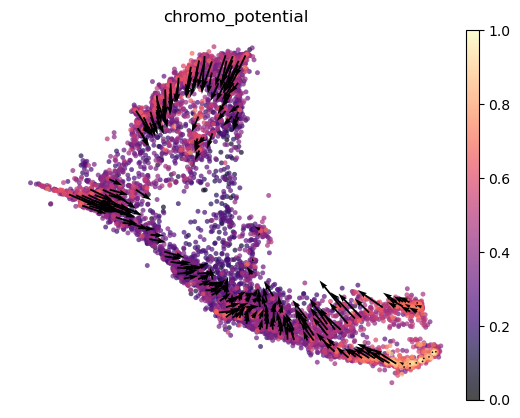

In [274]:
fig = plt.figure(figsize=[5,5])
x_smooth, y_smooth, u_smooth, v_smooth = smooth_arrows(x[:, 0], x[:, 1], 
                                                           v[:, 0], v[:, 1],
                                                           smooth_w=60, min_count=10)
E_norm_smooth = np.sqrt(u_smooth**2 + v_smooth**2)

ax = sc.pl.umap(adata_mvi2, color='smooth_chrome', title='chromo_potential', size = 50, alpha = 0.7, add_outline=False, frameon=False,
        outline_width=(0.1,0),show=False, color_map="magma")
ax.quiver(x_smooth, y_smooth,
              u_smooth, v_smooth,
               angles='xy', scale_units='xy') 
# ax.quiver(x[:, 0], x[:, 1], v[:, 0], v[:, 1],
        #        angles='xy', scale_units='xy')                

In [275]:
import torch
import torch.nn as nn
import torch.optim as optim

class RegressionMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to first Hidden Layer
        self.relu = nn.ReLU()  # Non-linear activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # First Hidden to Second Hidden Layer
        self.relu2 = nn.ReLU()  # Second ReLU for non-linearity in deep network
        self.fc3 = nn.Linear(hidden_size, output_size)  # Second Hidden to Output Layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)  # No activation, direct output
        return out


input_size = 20  # Number of input features
hidden_size = 50  # Neurons in each hidden layer
output_size = 20  # The output layer size (10-dimensional vector as required)

model = RegressionMLP(input_size, hidden_size, output_size)
print(model)



RegressionMLP(
  (fc1): Linear(in_features=20, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=20, bias=True)
)


In [349]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [350]:
torch.manual_seed(0)

# Dummy input (100 samples, 15 features each)
x_train = torch.tensor(adata_mvi2.obsm["latent_atac"])
# Dummy output (100 samples, 10 output values each)
y_train = torch.tensor(adata_mvi2.obsm["latent_expr"])

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # Clear gradients for the next train
    outputs = model(x_train)  # Forward pass: Compute prediction by passing x to the model
    loss = criterion(outputs, y_train)  # Compute loss
    loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step()  # Optimizer: update model parameters

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1000/10000], Loss: 0.4996
Epoch [2000/10000], Loss: 0.4996
Epoch [3000/10000], Loss: 0.4996
Epoch [4000/10000], Loss: 0.4996
Epoch [5000/10000], Loss: 0.4996
Epoch [6000/10000], Loss: 0.4996
Epoch [7000/10000], Loss: 0.4996
Epoch [8000/10000], Loss: 0.4996
Epoch [9000/10000], Loss: 0.4996
Epoch [10000/10000], Loss: 0.4996


In [351]:
torch.save(model.state_dict(), "data/hair_chromo_potential_mlp.pth")


In [402]:
input_size = 10  # Number of input features
hidden_size = 50  # Neurons in each hidden layer
output_size = 10  # The output layer size (10-dimensional vector as required)

model2 = RegressionMLP(input_size, hidden_size, output_size)


In [403]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.005)

In [411]:
torch.manual_seed(0)

# Dummy input (100 samples, 15 features each)
x_train = torch.tensor(adata_mvi2.obsm["latent_atac"][:,:10])
# Dummy output (100 samples, 10 output values each)
y_train = torch.tensor(adata_mvi2.obsm["latent_expr"][:,:10])

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Clear gradients for the next train
    outputs = model2(x_train)  # Forward pass: Compute prediction by passing x to the model
    loss = criterion(outputs, y_train)  # Compute loss
    loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
    optimizer.step()  # Optimizer: update model parameters

    if (epoch+1) % 10000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10000/100000], Loss: 0.3063
Epoch [20000/100000], Loss: 0.3067
Epoch [30000/100000], Loss: 0.3091
Epoch [40000/100000], Loss: 0.3067
Epoch [50000/100000], Loss: 0.3058
Epoch [60000/100000], Loss: 0.3106
Epoch [70000/100000], Loss: 0.3047
Epoch [80000/100000], Loss: 0.3053
Epoch [90000/100000], Loss: 0.3052
Epoch [100000/100000], Loss: 0.3058


In [412]:
# pred_expr = model(x_train)
# pred_expr.shape

pred_expr = model2(x_train)
pred_expr.shape

torch.Size([6431, 10])

In [413]:
pred_expr = pred_expr.detach().numpy()
pred_expr.shape

(6431, 10)

In [414]:
adata_mvi2.obsm["latent_expr_pred2"] = pred_expr
adata_mvi2.obsm["latent_expr_couple"] = adata_mvi2.obsm["latent_expr"][:,:10]

In [378]:
def calc_velocity2(d, pred_key='latent_atac', 
                     obs_key='latent_expr', max_per_cell=10, drange=range(20),
                     umap_key='umap', metric='correlation', batch=None,smoothcells=10):
    """Calculate chromatin potential.
    
    Parameters
    ----------
    d : dictionary
        Dictionary with predicted and observed gene expression.
    pred_key : str
        Key in dictionary containing predicted gene expression.
    obs_key : str
        Key in dictionary containing observed gene expression.
    max_per_cell : int
        Number of neighbors to compute chromatin potential over.
    umap_key : str
        Key to access UMAP or FDL coordinates.
    metric : str
        Metric to use to estimate similarity between predicted and 
        observed gene expression.
    batch : str
        Not implemented.
    
    Returns
    -------
    umap, V, M
        Arrow coordinates and length of arrows.
    """

    yp = d.obsm[pred_key][:,drange]
    yo = d.obsm[obs_key][:,drange]
    umap = d.obsm['X_' + umap_key] \
                    if batch is None \
                    else d['scvelo_batch_' + str(batch)].obsm['X_' + umap_key]

    
    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=max_per_cell, n_jobs=-1, metric=metric) 
    nn.fit(yp)
    dists, neighs = nn.kneighbors(yo)
    us = []
    vs = []
    cutoff = 0.95
    umap_new_unsmooth = np.zeros(umap.shape)
    umap_new = np.zeros(umap.shape)
    arrow_length = np.zeros(umap.shape[0])
    arrow_length_unsmooth = np.zeros(umap.shape[0])
    arrow_length_new = np.zeros(arrow_length.shape)
    
    M = np.zeros((yp.shape[0], yo.shape[0]))
    M[:] = np.inf

    for gx in range(yp.shape[0]):
        umap_new_unsmooth[gx] = umap[neighs[gx]].mean(0)
        M[gx][neighs[gx]] = dists[gx]
        
    for gx in range(yp.shape[0]):
        arrow_length_unsmooth[gx] = ((umap[gx][0] - umap_new[gx][0])**2 + (umap[gx][1] - umap_new[gx][1])**2)**0.5
    umap_new_unsmooth[arrow_length_unsmooth > np.quantile(arrow_length_unsmooth, cutoff)] = umap[arrow_length_unsmooth > np.quantile(arrow_length_unsmooth, cutoff)]


    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=smoothcells, n_jobs=-1, metric='euclidean')
    nn.fit(umap)
    dists, neighs = nn.kneighbors(umap)

    for gx in range(umap.shape[0]):
        umap_new[gx] = umap_new_unsmooth[neighs[gx]].mean(0)
        
    for gx in range(yp.shape[0]):
        arrow_length[gx] = ((umap[gx][0] - umap_new[gx][0])**2 + (umap[gx][1] - umap_new[gx][1])**2)**0.5

    umap_new[arrow_length > np.quantile(arrow_length, cutoff)] = umap[arrow_length > np.quantile(arrow_length, cutoff)]
    dX = umap_new - umap
    
    V = dX 
    return(umap, V, M)

<Figure size 500x500 with 0 Axes>

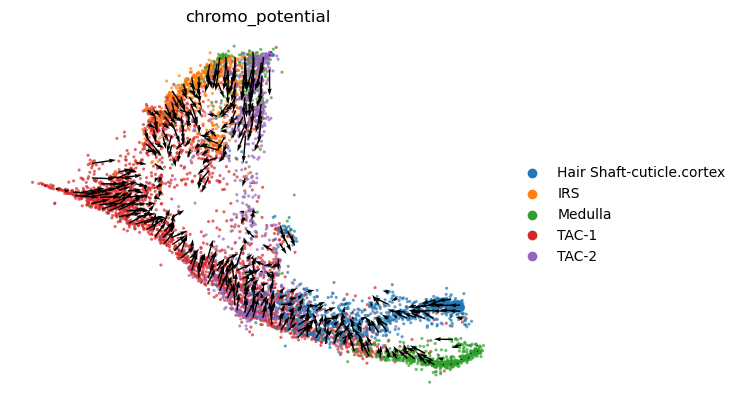

In [415]:
# x, v, M = calc_velocity(adata_mvi2, umap_key='umap2',pred_key='latent_expr_pred2', obs_key='latent_expr', max_per_cell=30, smoothcells=20)

# fig = plt.figure(figsize=[5,5])
# x_smooth, y_smooth, u_smooth, v_smooth = smooth_arrows(x[:, 0], x[:, 1], 
#                                                         v[:, 0], v[:, 1],
#                                                         smooth_w=50, min_count=5)
# E_norm_smooth = np.sqrt(u_smooth**2 + v_smooth**2)

# ax = sc.pl.umap(adata_mvi2, color='celltype', title='chromo_potential', size = 20, alpha = 0.7, add_outline=False, frameon=False,
#         outline_width=(0.1,0),show=False, color_map="magma")
# ax.quiver(x_smooth, y_smooth,
#         u_smooth, v_smooth,
#         angles='xy', scale_units='xy')
# 
x, v, M = calc_velocity(adata_mvi2, umap_key='umap2',pred_key='latent_expr_pred2', obs_key='latent_expr_couple', max_per_cell=10, smoothcells=10)

fig = plt.figure(figsize=[5,5])
x_smooth, y_smooth, u_smooth, v_smooth = smooth_arrows(x[:, 0], x[:, 1], 
                                                        v[:, 0], v[:, 1],
                                                        smooth_w=50, min_count=5)
E_norm_smooth = np.sqrt(u_smooth**2 + v_smooth**2)

ax = sc.pl.umap(adata_mvi2, color='celltype', title='chromo_potential', size = 20, alpha = 0.7, add_outline=False, frameon=False,
        outline_width=(0.1,0),show=False, color_map="magma")
ax.quiver(x_smooth, y_smooth,
        u_smooth, v_smooth,
        angles='xy', scale_units='xy')  

In [421]:
adata_mvi2.obs["v_dist"] = result["sclink"]


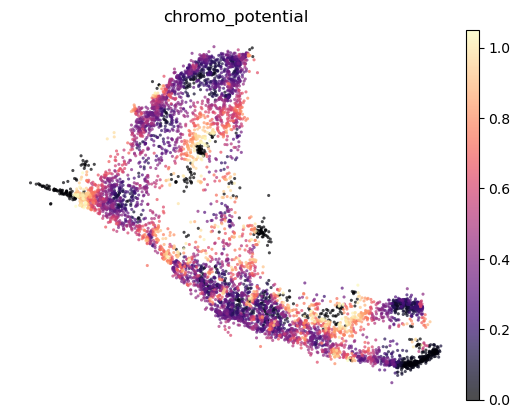

In [422]:
ax = sc.pl.umap(adata_mvi2, color='v_dist', title='chromo_potential', size = 20, alpha = 0.7, add_outline=False, frameon=False,
        outline_width=(0.1,0),show=False, color_map="magma")

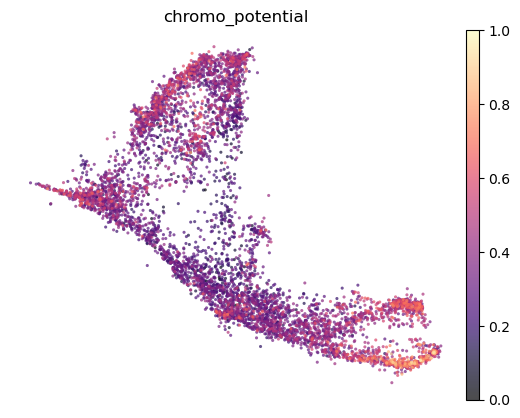

In [423]:
ax = sc.pl.umap(adata_mvi2, color='smooth_chrome', title='chromo_potential', size = 20, alpha = 0.7, add_outline=False, frameon=False,
        outline_width=(0.1,0),show=False, color_map="magma")

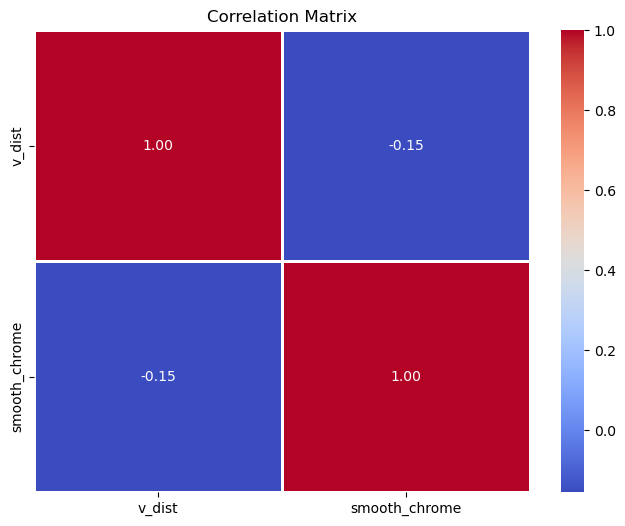

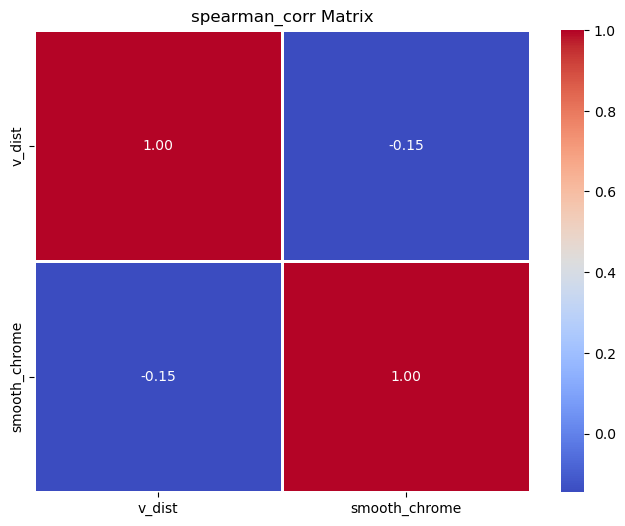

In [426]:
import seaborn as sns
correlation_matrix = adata_mvi2.obs[["v_dist", "smooth_chrome"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=2)
plt.title('Correlation Matrix')
plt.show()
# Spearman's rank correlation
spearman_corr = adata_mvi2.obs[["v_dist","smooth_chrome"]].corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=2)
plt.title('spearman_corr Matrix')
plt.show()

In [401]:
# for i in range(5,26,5):
#         print(i)
#         x, v, M = calc_velocity2(adata_mvi2, umap_key='umap2',pred_key='latent_expr_pred2', obs_key='latent_expr', max_per_cell=50, smoothcells=20, drange=range(i-5,i))

#         fig = plt.figure(figsize=[5,5])
#         x_smooth, y_smooth, u_smooth, v_smooth = smooth_arrows(x[:, 0], x[:, 1], 
#                                                                 v[:, 0], v[:, 1],
#                                                                 smooth_w=50, min_count=5)
#         E_norm_smooth = np.sqrt(u_smooth**2 + v_smooth**2)

#         ax = sc.pl.umap(adata_mvi2, color='celltype', title='chromo_potential', size = 20, alpha = 0.7, add_outline=False, frameon=False,
#                 outline_width=(0.1,0),show=False, color_map="magma")
#         ax.quiver(x_smooth, y_smooth,
#                 u_smooth, v_smooth,
#                 angles='xy', scale_units='xy') 


In [416]:
result["v_0_halo"] = v[:, 0]
result["v_1_halo"] = v[:, 1]

In [417]:
result["sclink"] =(result['v_0']**2 + result['v_1']**2)**0.5
result["chropot"] =(result['v_0_halo']**2 + result['v_1_halo']**2)**0.5

In [419]:
import seaborn as sns
correlation_matrix = result[["v_0", "v_1", "v_0_halo", "v_1_halo","sclink", "chropot","smooth_chrome"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=2)
plt.title('Correlation Matrix')
plt.show()
# Spearman's rank correlation
spearman_corr = result[["v_0", "v_1", "v_0_halo", "v_1_halo","sclink", "chropot","smooth_chrome"]].corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=2)
plt.title('spearman_corr Matrix')
plt.show()

KeyError: "['smooth_chrome'] not in index"